# Chapter 2
## Multi-armed Bandits

### 2.2 Action-value Methods

#### Exercise 2.1
In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is
the probability that the greedy action is selected?

- ***0.75***

### 2.3 The 10-armed Testbed

In [1]:
import gymnasium as gym
from utils import run_experiment, plot_experiment, run_parameter_study, plot_parameter_study
from agents import SampleAverageAgent, ConstantStepSizeAgent, UpperConfidenceBoundAgent, GradientAgent

k = 10
seed = 42
num_envs = 2000

#### Figure 2.1

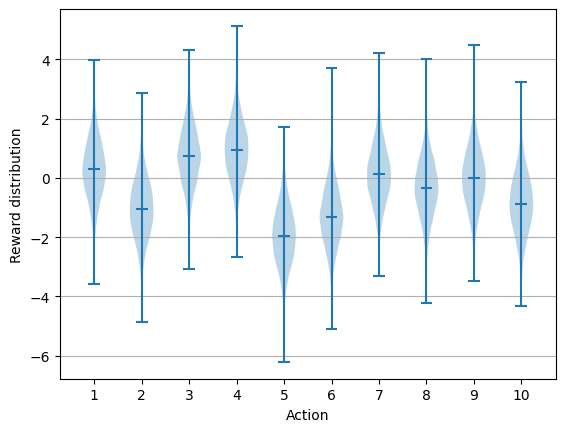

In [2]:
vector_kwargs = dict(k=k, stationary=True)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)

env.reset(seed=seed)
env.render(env_index=0)

#### Figure 2.2

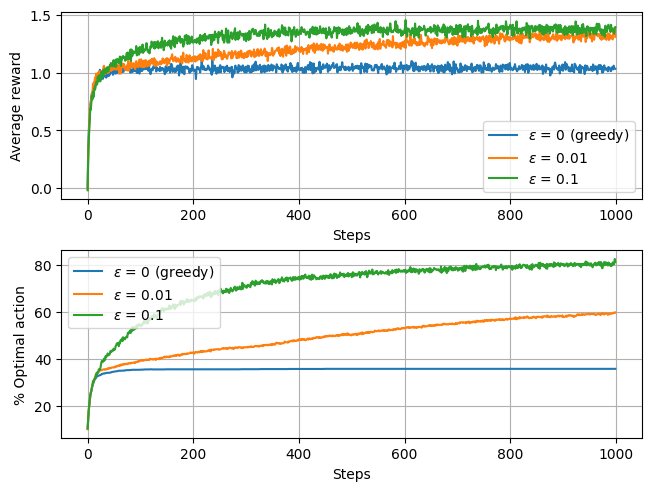

In [3]:
agents = {
    r"$\epsilon$ = 0 (greedy)": SampleAverageAgent(k, num_envs, epsilon=0.0),
    r"$\epsilon$ = 0.01": SampleAverageAgent(k, num_envs, epsilon=0.01),
    r"$\epsilon$ = 0.1": SampleAverageAgent(k, num_envs, epsilon=0.1)
}

data = run_experiment(env, agents, seed)
plot_experiment(data)

#### Exercise 2.2: Bandit example
Consider a $k$-armed bandit problem with $k = 4$ actions, denoted $1$, $2$, $3$, and $4$. Consider applying to this problem a bandit algorithm using $\epsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1 = 1$, $R_1 = −1$, $A_2 = 2$, $R_2 = 1$, $A_3 = 2$, $R_3 = −2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$. On some of these time steps the $\epsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

- ***Definitely occured on $t = 4$ and $t = 5$***

- ***Possibly have ocurred on $t = 1$, $t = 2$ and $t = 3$***

#### Exercise 2.3
In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

- ***$\epsilon = 0.01$ will perform best in the long run***
- ***In the long run, the probability of selecting the best action will be $(1 - \epsilon) + \epsilon / k = 1 - (k - 1) \epsilon / k$, which indicates that the lower the $\epsilon$, the greater the probability***
- ***% Optimal action: $99.1\%$***

### 2.5 Tracking a Nonstationary Problem

#### Exercise 2.4
If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting diferent from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

- ***$Q_{n+1} = Q_1 \prod_{i=1}^n (1-\alpha_i) + \sum_{i=1}^n a_iR_i \prod_{j=i+1}^n (1-a_j)$***

#### Exercise 2.5 (programming)
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean $0$ and standard deviation $0.01$ to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.

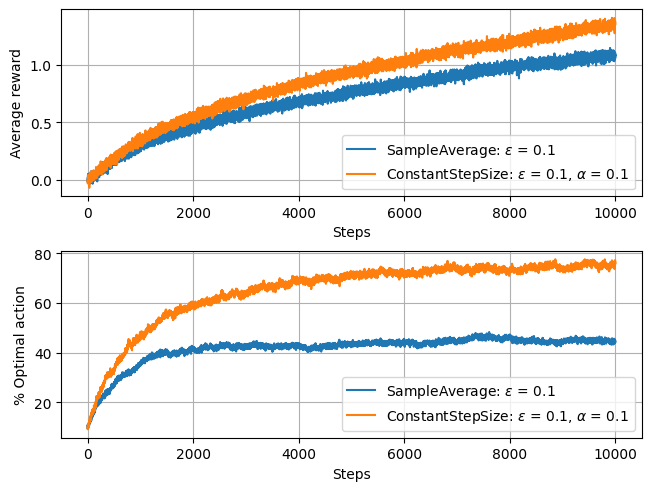

In [4]:
vector_kwargs = dict(k=k, stationary=False)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)
env.max_episode_steps = 10000

agents = {
    r"SampleAverage: $\epsilon$ = 0.1": SampleAverageAgent(k, num_envs, epsilon=0.1),
    r"ConstantStepSize: $\epsilon$ = 0.1, $\alpha$ = 0.1": ConstantStepSizeAgent(k, num_envs, epsilon=0.1, alpha=0.1)
}

data = run_experiment(env, agents, seed)
plot_experiment(data)

### 2.6 Optimistic Initial Values

#### Figure 2.3

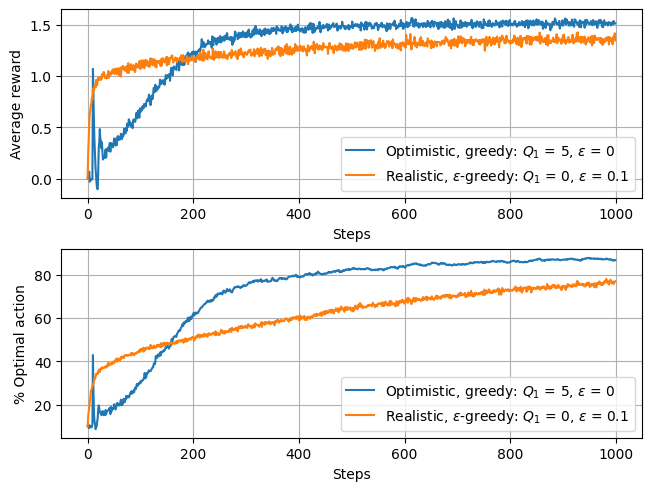

In [5]:
vector_kwargs = dict(k=k, stationary=True)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)

agents = {
    r"Optimistic, greedy: $Q_1$ = 5, $\epsilon$ = 0": ConstantStepSizeAgent(k, num_envs, epsilon=0, alpha=0.1, init_val=5.0),
    r"Realistic, $\epsilon$-greedy: $Q_1$ = 0, $\epsilon$ = 0.1": ConstantStepSizeAgent(k, num_envs, epsilon=0.1, alpha=0.1)
}

data = run_experiment(env, agents, seed)
plot_experiment(data)

#### Exercise 2.6: Mysterious Spikes
The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

- ***The fitst 10 steps lower the optimistic initial values proportional to the error in the estimate, the 11th step chooses greedily from the new estimates with a higher probability of choosing the optimal action***
- ***Steps 12 to 20 keep lowering the estimates closer to the the true values, increasing slightly the probability of choosing the optimal action by step 21st. This effect rapidly desapears due to randomness in the rewards***

#### Exercise 2.7: Unbiased Constant-Step-Size Trick
In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of

$\beta_n \doteq \alpha/\bar o_n$

to process the *n*th reward for a particular action, where $\alpha > 0$ is a conventional constant step size, and $\bar o_n$ is a trace of one that starts at $0$:

$\bar o_n \doteq \bar o_{n-1} + \alpha(1-\bar o_{n-1})$, for $n > 0$, with $\bar o_0 \doteq 0$.

Carry out an analysis like that in (2.6) to show that $Q_n$ is an exponential recency-weighted average *without initial bias*.

- ***$Q_{n+1} = \frac{\sum_{i=1}^n (1-\alpha)^{n-i}R_i}{\sum_{i=1}^n (1-\alpha)^{n-i}} = \frac{\alpha}{1-(1-\alpha)^n} \sum_{i=1}^n (1-\alpha)^{n-i}R_i$***

### 2.7 Upper-Confidence-Bound Action Selection

#### Figure 2.4

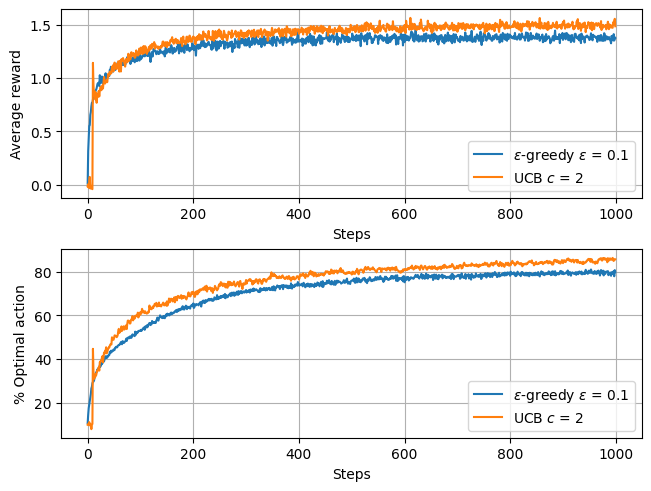

In [6]:
vector_kwargs = dict(k=k, stationary=True)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)

agents = {
    r"$\epsilon$-greedy $\epsilon$ = 0.1": SampleAverageAgent(k, num_envs, epsilon=0.1),
    r"UCB $c$ = 2": UpperConfidenceBoundAgent(k, num_envs, c=2)
}

data = run_experiment(env, agents, seed)
plot_experiment(data)

#### Exercise 2.8: UCB Spikes
In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If $c = 1$, then the spike is less prominent.

- ***The fitst 10 steps initialize the estimate values, the 11th step chooses greedily from the new estimates because all confidence intervals have the same length for all actions.***
- ***After the update on the estimate by step 11th, the confidence interval of that actions is reduced. If the exploration parameter $c$ is greater, it will probably explore actions with a greater upper confidence interval; if the $c$ parameter is lower, it will probably exploit more the same action until its upper confidence interval is low enough to chose another action***

### 2.8 Gradient Bandit Algorithms

#### Exercise 2.9
Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.

- ***$Pr\{A_t=1\} = \frac{1}{1+e^{H_t(2)-H_t(1)}} = \sigma(H_t(1)-H_t(2))$***
- ***$Pr\{A_t=2\} = \frac{1}{1+e^{H_t(1)-H_t(2)}} = \sigma(H_t(2)-H_t(1))$***

#### Figure 2.5

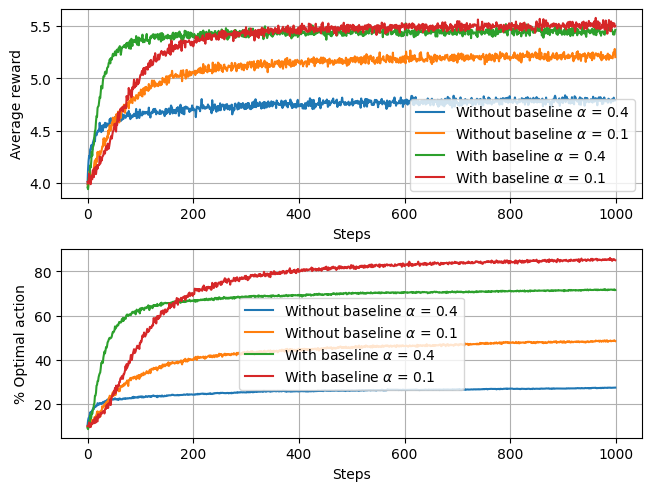

In [7]:
vector_kwargs = dict(k=k, stationary=True, mean=4.0)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)

agents = {
    r"Without baseline $\alpha$ = 0.4": GradientAgent(k, num_envs, alpha=0.4),
    r"Without baseline $\alpha$ = 0.1": GradientAgent(k, num_envs, alpha=0.1),
    r"With baseline $\alpha$ = 0.4": GradientAgent(k, num_envs, alpha=0.4, use_baseline=True),
    r"With baseline $\alpha$ = 0.1": GradientAgent(k, num_envs, alpha=0.1, use_baseline=True)
}

data = run_experiment(env, agents, seed)
plot_experiment(data)

### 2.9 Associative Search (Contextual Bandits)

#### Exercise 2.10
Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 10 and 20 with probability 0.5 (case A), and 90 and 80 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expected reward you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expected reward you can achieve in this task, and how should you behave to achieve it?

- ***If you are not able to tell wich case you face at any step, the best (and only) expected reward is 50, independent of the aciton chosen***

    ***$p_1 = P[A_t=1]$***
    
    ***$E[R_t] = p_1 * (0.5 * 10 + 0.5 * 90) + (1-p_1) * (0.5 * 20 + 0.5 * 80) = 50$***

- ***In the associative search task, the best expected reward is 55. It can be acheived (having different $Q_t(a)$ estimates for each state) by an $\epsilon$-greedy algorithm, decreasing the exploration parameter $\epsilon$ over time, until the algorithm behaves greedily***

    ***$E[R_t] = 0.5 * E[R_t|caseA] + 0.5 * E[R_t|caseB]$***
    
    ***$E[R_t] = 0.5 * 20 + 0.5 * 90 = 55$ (under an optimal policy)***

#### Figure 2.6

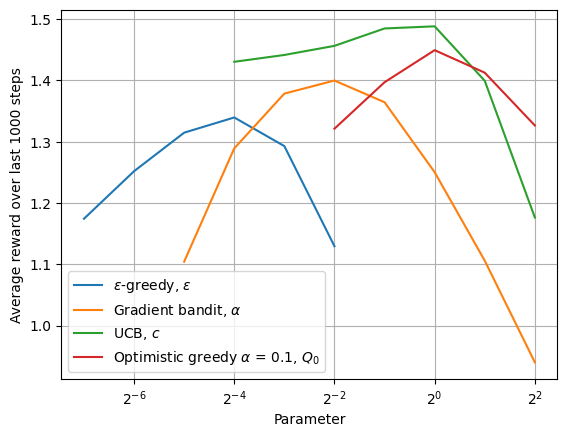

In [8]:
vector_kwargs = dict(k=k, stationary=True)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)

study = {
    r"$\epsilon$-greedy, $\epsilon$": {
        "entry_point": SampleAverageAgent,
        "parameter": {"epsilon": [2**i for i in range(-7, -1)]}
    },
    r"Gradient bandit, $\alpha$": {
        "entry_point": GradientAgent,
        "parameter": {"alpha": [2**i for i in range(-5, 3)]}
    },
    r"UCB, $c$": {
        "entry_point": UpperConfidenceBoundAgent,
        "parameter": {"c": [2**i for i in range(-4, 3)]}
    },
    r"Optimistic greedy $\alpha$ = 0.1, $Q_0$": {
        "entry_point": ConstantStepSizeAgent,
        "parameter": {"init_val": [2**i for i in range(-2, 3)]},
        "constant_parameters": {"epsilon": 0.0, "alpha": 0.1}
    }
}

data = run_parameter_study(env, study, seed=seed)
plot_parameter_study(data)

#### Exercise 2.11 (programming)
Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha = 0.1$. Use runs of 200,000 steps and, as a performance measure for each algorithm and
parameter setting, use the average reward over the last 100,000 steps.

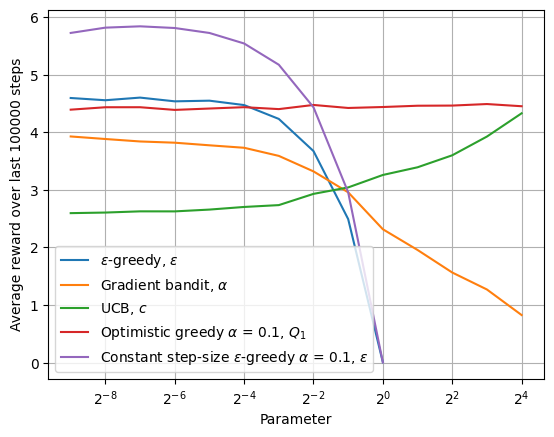

In [9]:
vector_kwargs = dict(k=k, stationary=False)
env = gym.make_vec("ArmedBanditTestbed-v0", num_envs, "custom", vector_kwargs)
env.max_episode_steps = 200000

study = {
    r"$\epsilon$-greedy, $\epsilon$": {
        "entry_point": SampleAverageAgent,
        "parameter": {"epsilon": [2**i for i in range(-9, 1)]}
    },
    r"Gradient bandit, $\alpha$": {
        "entry_point": GradientAgent,
        "parameter": {"alpha": [2**i for i in range(-9, 5)]}
    },
    r"UCB, $c$": {
        "entry_point": UpperConfidenceBoundAgent,
        "parameter": {"c": [2**i for i in range(-9, 5)]}
    },
    r"Optimistic greedy $\alpha$ = 0.1, $Q_1$": {
        "entry_point": ConstantStepSizeAgent,
        "parameter": {"init_val": [2**i for i in range(-9, 5)]},
        "constant_parameters": {"epsilon": 0.0, "alpha": 0.1}
    },
    r"Constant step-size $\epsilon$-greedy $\alpha$ = 0.1, $\epsilon$": {
        "entry_point": ConstantStepSizeAgent,
        "parameter": {"epsilon": [2**i for i in range(-9, 1)]},
        "constant_parameters": {"alpha": 0.1}
    }
}

data = run_parameter_study(env, study, last_steps=100000, seed=seed)
plot_parameter_study(data)